Training samples:   229
Validation samples: 127
Future (unlabeled) samples: 0

--- Training RNN ---
Epoch 50/200: train_loss=0.000742, val_loss=0.014715
RNN final best val_loss=0.014715

--- Training LSTM ---
LSTM final best val_loss=0.002243

--- Training GRU ---
Epoch 50/200: train_loss=0.000672, val_loss=0.001011
GRU final best val_loss=0.000877

--- Training CNN ---
CNN final best val_loss=0.002221

--- Training EnhancedLSTM ---
Epoch 50/200: train_loss=0.044868, val_loss=0.055289
Epoch 100/200: train_loss=0.023055, val_loss=0.028129
EnhancedLSTM final best val_loss=0.019129
[RNN] Validation MAPE = 6.26%
[LSTM] Validation MAPE = 8.09%
[GRU] Validation MAPE = 1.43%
[CNN] Validation MAPE = 2.76%
[EnhancedLSTM] Validation MAPE = 8.90%


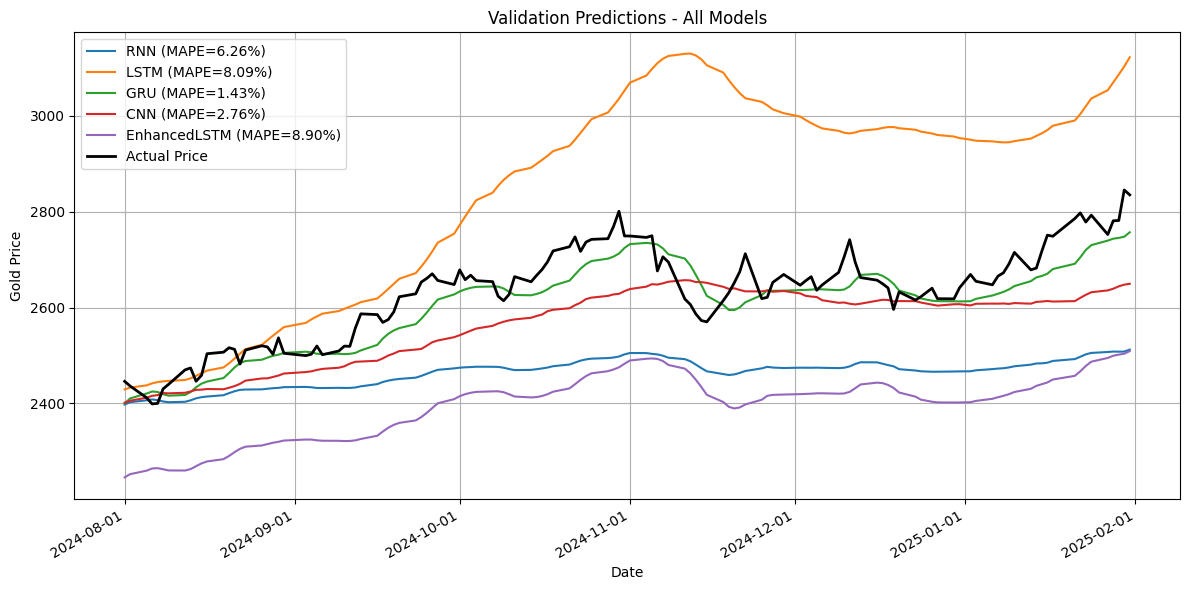

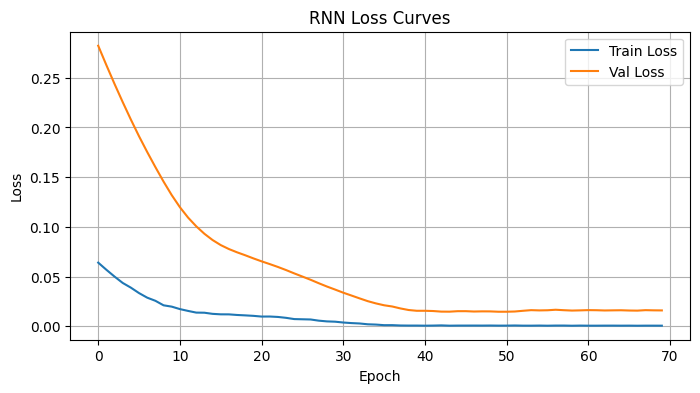

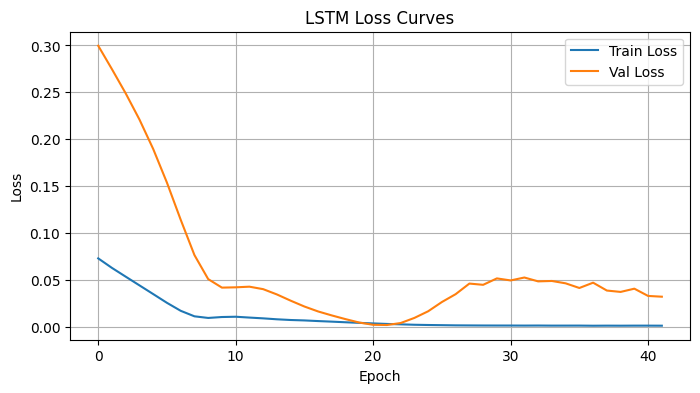

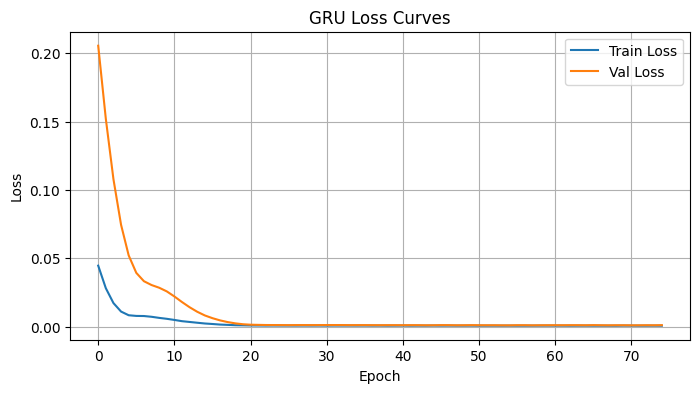

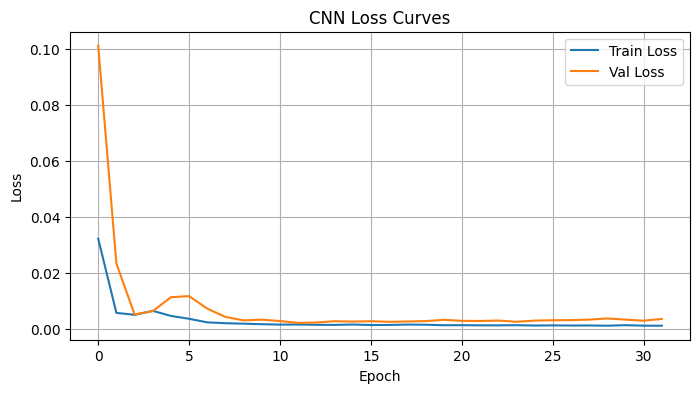

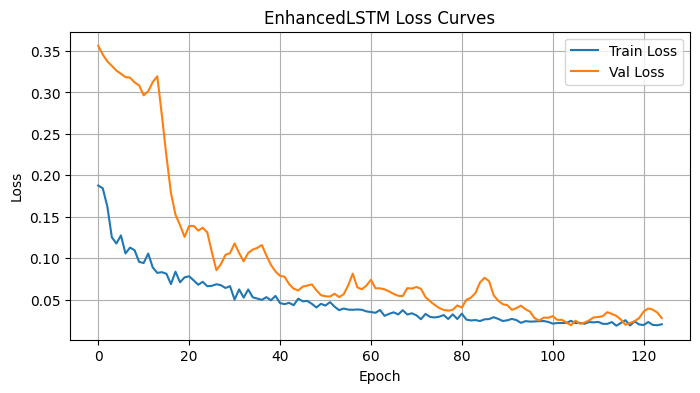

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random
import os
import warnings
import matplotlib.dates as mdates

# ------------------------------------------------------------------------------
# 1) Reproducibility & Device setup
# ------------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------------------------------------------------
# 2) Load & preprocess your dataset
# ------------------------------------------------------------------------------
df = pd.read_csv('Gold Futures Historical Data_1Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

num_cols = df.columns.drop('Date')
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Basic checks
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

window_width = 30  # Sequence length

X, y, all_dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width : i])
    # target = next day's Price
    y.append(data_scaled[i, 0])  # Price is index 0
    all_dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
all_dates = np.array(all_dates)
assert len(X) == len(y) == len(all_dates)

# ------------------------------------------------------------------------------
# 3) Train/Validation split (optional future split)
# ------------------------------------------------------------------------------
# Example: use data before 2024-08-01 for training, 2024-08-01 to 2025-01-31 for validation,
# and beyond 2025-01-31 as future data (unlabeled).
train_cutoff = pd.to_datetime('2024-08-01')
val_cutoff   = pd.to_datetime('2025-01-31')

train_mask  = all_dates < train_cutoff
val_mask    = (all_dates >= train_cutoff) & (all_dates <= val_cutoff)
future_mask = all_dates > val_cutoff  # purely future (no real labels)

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_future         = X[future_mask]
train_dates      = all_dates[train_mask]
val_dates        = all_dates[val_mask]
future_dates     = all_dates[future_mask]

print(f"Training samples:   {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Future (unlabeled) samples: {len(X_future)}")

# Convert to tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor   = torch.from_numpy(X_val).float()
y_val_tensor   = torch.from_numpy(y_val).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

# ------------------------------------------------------------------------------
# 4) Define your model classes: RNN, LSTM, GRU, CNN, EnhancedLSTM
# ------------------------------------------------------------------------------
class RNNModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity='relu',
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

class CNNModel(nn.Module):
    def __init__(self, in_channels=4, c1=64, c2=128, dropout=0.1, window_size=30):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, c1, kernel_size=3)
        self.conv2 = nn.Conv1d(c1, c2, kernel_size=3)
        self.dropout = nn.Dropout(dropout)
        
        # Output length after two Conv1d layers with kernel_size=3 each
        conv_out_len = window_size - 2*(3 - 1)
        self.fc = nn.Linear(c2 * conv_out_len, 1)

    def forward(self, x):
        # x: [batch, seq_len, features]
        x = x.permute(0, 2, 1)  # -> [batch, channels, seq_len]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out

class EnhancedLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=128, num_layers=3, dropout=0.2):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# ------------------------------------------------------------------------------
# 5) EarlyStopping class
# ------------------------------------------------------------------------------
class EarlyStopping:
    def __init__(self, patience=50, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > (self.best_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------------------
# 6) Inverse transform for 'Price'
# ------------------------------------------------------------------------------
def inverse_transform(y_scaled):
    """
    Revert scaled 'Price' to the original scale. 
    """
    y_scaled = np.array(y_scaled).reshape(-1,1)
    # dummy zeros for the other 3 features
    zeros = np.zeros((y_scaled.shape[0], len(features)-1))
    combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(combined)
    return y_inv[:, 0]

# ------------------------------------------------------------------------------
# 7) Single training routine
# ------------------------------------------------------------------------------
def train_model(model, train_loader, val_loader, lr=1e-4, max_epochs=200, patience=20):
    """
    Trains a given model with AdamW + HuberLoss + ReduceLROnPlateau.
    Returns the best model (on validation), the training/validation loss curves,
    and the best validation loss value.
    """
    model.to(device)
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience)
    
    early_stopper = EarlyStopping(patience=patience, min_delta=0)
    best_val_loss = float('inf')
    
    train_losses = []
    val_losses   = []
    best_state   = None

    for epoch in range(max_epochs):
        # --- TRAIN ---
        model.train()
        epoch_train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())
        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)

        # --- VALIDATE ---
        model.eval()
        epoch_val_losses = []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb)
                v_loss = criterion(preds, yb)
                epoch_val_losses.append(v_loss.item())
        avg_val_loss = np.mean(epoch_val_losses)
        val_losses.append(avg_val_loss)

        # Step scheduler
        scheduler.step(avg_val_loss)
        # Early stopping check
        early_stopper(avg_val_loss)
        if early_stopper.early_stop:
            # print(f"Early stopping at epoch {epoch+1}")
            break

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()

        # (Optional) Print progress every 50 epochs
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{max_epochs}: train_loss={avg_train_loss:.6f}, val_loss={avg_val_loss:.6f}")

    # restore best weights
    model.load_state_dict(best_state)
    return model, train_losses, val_losses, best_val_loss

# ------------------------------------------------------------------------------
# 8) Helper to evaluate a model on validation set
# ------------------------------------------------------------------------------
def evaluate_on_validation(model, X_val, y_val):
    model.eval()
    pred_list = []
    with torch.no_grad():
        data_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
        for Xb, _ in data_loader:
            Xb = Xb.to(device)
            preds = model(Xb)
            pred_list.append(preds.cpu().numpy())
    all_preds_scaled = np.concatenate(pred_list, axis=0).ravel()
    
    # invert scale
    preds_unscaled = inverse_transform(all_preds_scaled)
    actual_unscaled = inverse_transform(y_val.numpy().ravel())
    
    # MAPE
    mape_val = mean_absolute_percentage_error(actual_unscaled, preds_unscaled)*100
    return preds_unscaled, actual_unscaled, mape_val

# ------------------------------------------------------------------------------
# 9) Train each model
# ------------------------------------------------------------------------------
model_types = {
    'RNN': RNNModel(input_size=len(features),  hidden_size=64,  num_layers=2, dropout=0.1),
    'LSTM': LSTMModel(input_size=len(features), hidden_size=128, num_layers=2, dropout=0.1),
    'GRU': GRUModel(input_size=len(features),  hidden_size=128, num_layers=2, dropout=0.1),
    'CNN': CNNModel(in_channels=len(features), c1=64, c2=128, dropout=0.1, window_size=window_width),
    'EnhancedLSTM': EnhancedLSTM(input_size=len(features), hidden_size=128, num_layers=3, dropout=0.2)
}

best_models = {}
histories = {}

for name, model_obj in model_types.items():
    print(f"\n--- Training {name} ---")
    trained_model, train_losses, val_losses, best_val = train_model(
        model_obj,
        train_loader,
        val_loader,
        lr=1e-4,      # Example LR
        max_epochs=200,
        patience=20
    )
    best_models[name] = trained_model
    histories[name]   = (train_losses, val_losses)

    print(f"{name} final best val_loss={best_val:.6f}")

# ------------------------------------------------------------------------------
# 10) Evaluate & Plot on Validation
# ------------------------------------------------------------------------------
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))

# We'll plot actual vs each model's predictions on validation
for name, model_obj in best_models.items():
    preds_unscaled, actual_unscaled, mape_val = evaluate_on_validation(model_obj, X_val_tensor, y_val_tensor)
    print(f"[{name}] Validation MAPE = {mape_val:.2f}%")
    plt.plot(val_dates, preds_unscaled, label=f'{name} (MAPE={mape_val:.2f}%)')

# Plot actual
plt.plot(val_dates, actual_unscaled, color='black', label='Actual Price', linewidth=2.0)

plt.title('Validation Predictions - All Models')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 11) Plot training/validation loss curves for each model
# ------------------------------------------------------------------------------
for name, (tr_loss, va_loss) in histories.items():
    plt.figure(figsize=(8,4))
    plt.plot(tr_loss, label='Train Loss')
    plt.plot(va_loss, label='Val Loss')
    plt.title(f'{name} Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------------------------------------------------------------
# 12) (Optional) Predict on future data if available (no real labels)
# ------------------------------------------------------------------------------
if len(X_future) > 0:
    X_future_tensor = torch.from_numpy(X_future).float().to(device)
    print("\nPredicting on future (unlabeled) data...\n")
    for name, model_obj in best_models.items():
        model_obj.eval()
        with torch.no_grad():
            future_preds_scaled = model_obj(X_future_tensor).cpu().numpy().ravel()
        future_preds_unscaled = inverse_transform(future_preds_scaled)

        print(f"--- {name} Future Predictions ---")
        for d, price_pred in zip(future_dates, future_preds_unscaled):
            print(f"{d.strftime('%Y-%m-%d')}: {price_pred:.2f}")
        print()



Training LSTM model...
[LSTM] Epoch 100/1500 -- Train Loss: 0.000597, Val Loss: 0.001947
Early stopping triggered
[LSTM] Early stopping at epoch 192
[LSTM] Best Validation Loss: 0.000840

Training GRU model...


/tmp/ipykernel_968974/605796867.py:296: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[GRU] Epoch 100/1500 -- Train Loss: 0.000910, Val Loss: 0.001152
[GRU] Epoch 200/1500 -- Train Loss: 0.000291, Val Loss: 0.000446
[GRU] Epoch 300/1500 -- Train Loss: 0.000326, Val Loss: 0.001509
Early stopping triggered
[GRU] Early stopping at epoch 302
[GRU] Best Validation Loss: 0.000389

Training RNN model...


/tmp/ipykernel_968974/605796867.py:296: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Epoch 100/1500 -- Train Loss: 0.000390, Val Loss: 0.000392
[RNN] Epoch 200/1500 -- Train Loss: 0.000388, Val Loss: 0.000748
Early stopping triggered
[RNN] Early stopping at epoch 281
[RNN] Best Validation Loss: 0.000373

Training CNN model...


/tmp/ipykernel_968974/605796867.py:296: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[CNN] Epoch 100/1500 -- Train Loss: 0.010674, Val Loss: 0.437208
[CNN] Epoch 200/1500 -- Train Loss: 0.001945, Val Loss: 0.092272
[CNN] Epoch 300/1500 -- Train Loss: 0.001996, Val Loss: 0.032887
[CNN] Epoch 400/1500 -- Train Loss: 0.013183, Val Loss: 0.012254
[CNN] Epoch 500/1500 -- Train Loss: 0.000485, Val Loss: 0.010777
[CNN] Epoch 600/1500 -- Train Loss: 0.000540, Val Loss: 0.014872
[CNN] Epoch 700/1500 -- Train Loss: 0.000360, Val Loss: 0.040515
[CNN] Epoch 800/1500 -- Train Loss: 0.000445, Val Loss: 0.020693
Early stopping triggered
[CNN] Early stopping at epoch 887
[CNN] Best Validation Loss: 0.002385

Training EnhancedLSTM model...


/tmp/ipykernel_968974/605796867.py:296: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[EnhancedLSTM] Epoch 100/1500 -- Train Loss: 0.001366, Val Loss: 0.007240
Early stopping triggered
[EnhancedLSTM] Early stopping at epoch 181
[EnhancedLSTM] Best Validation Loss: 0.001191


/tmp/ipykernel_968974/605796867.py:296: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


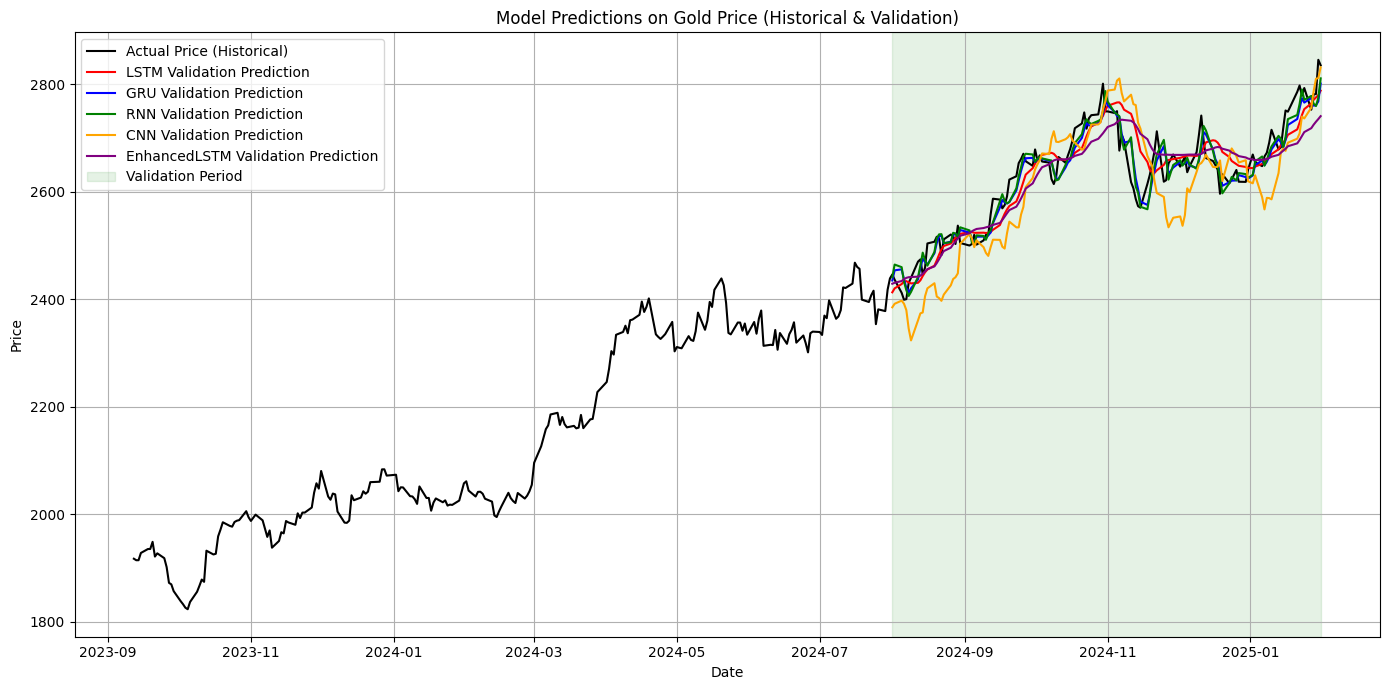

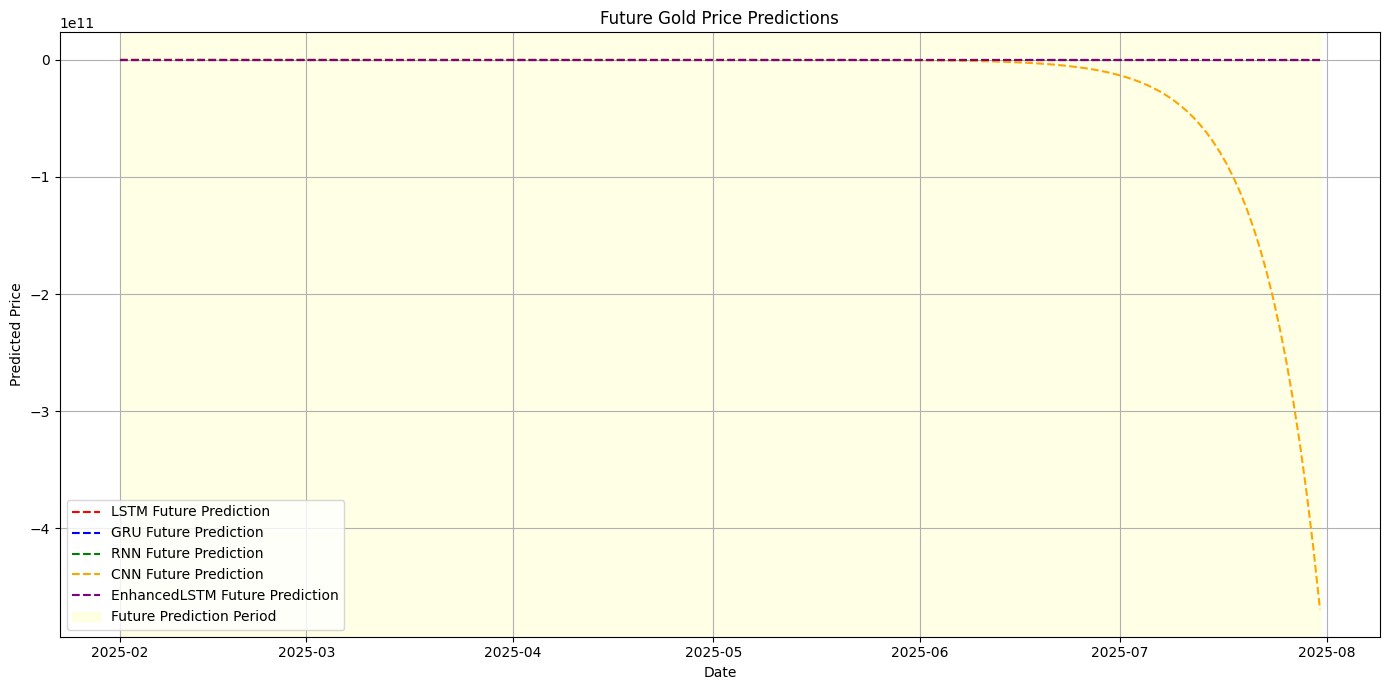

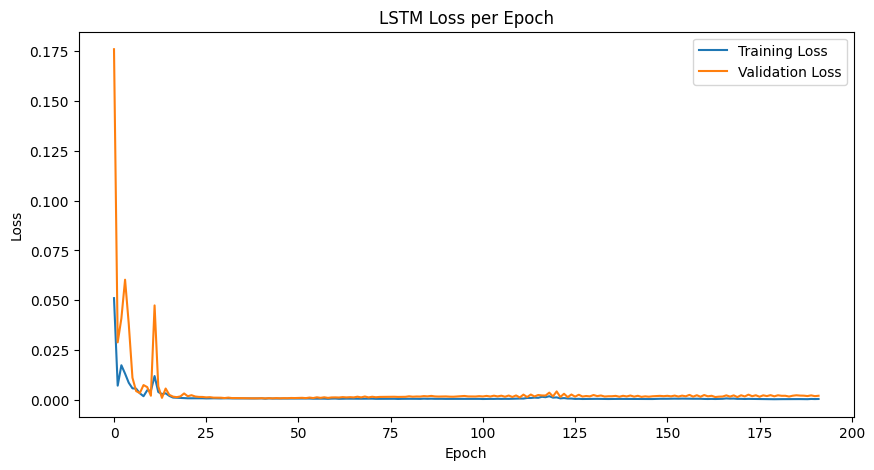

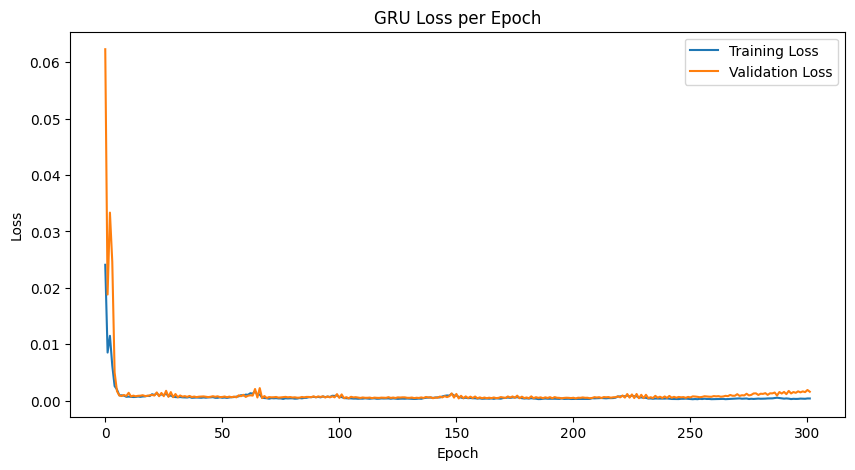

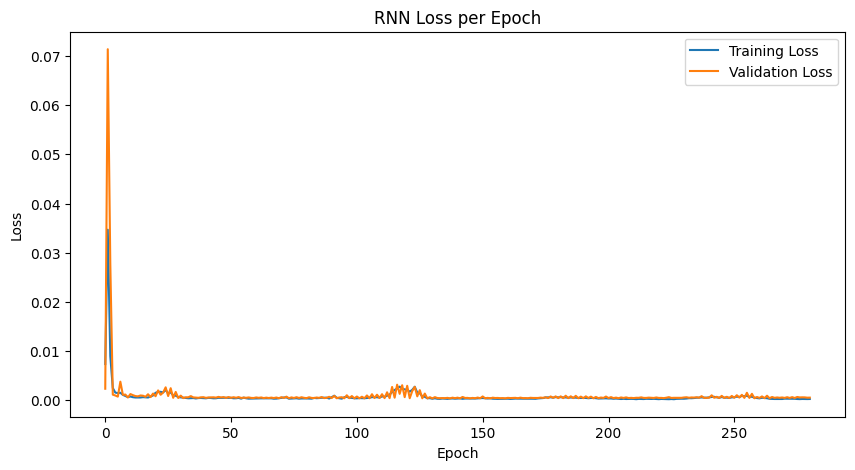

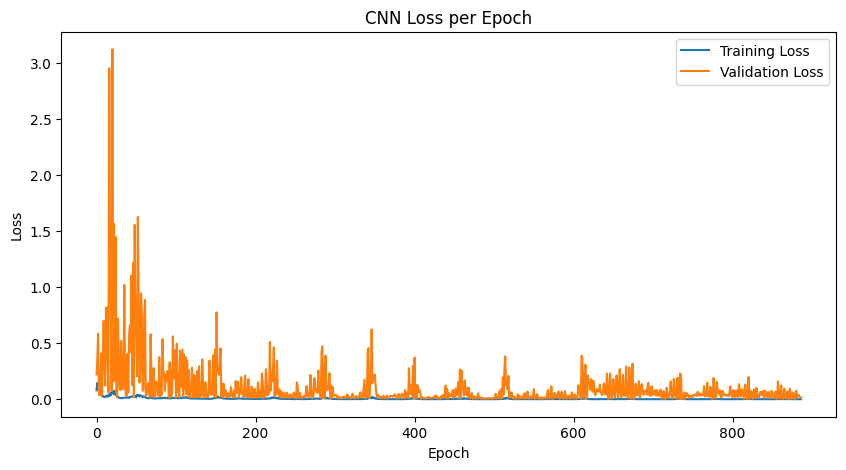

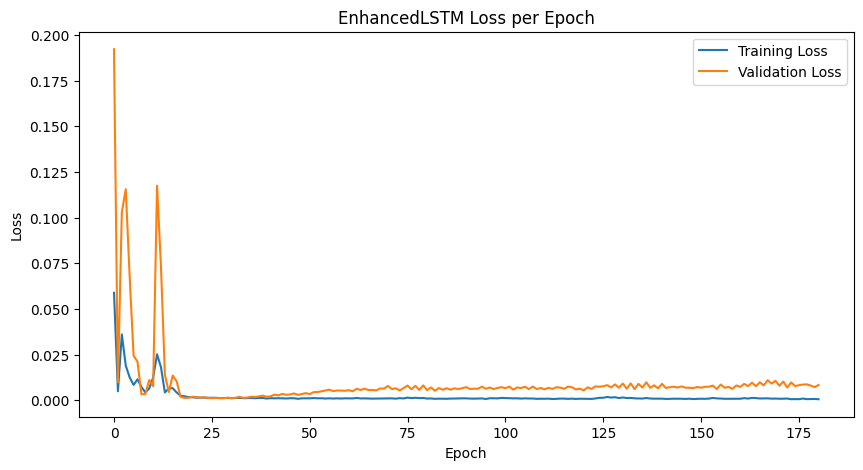

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# -----------------------
# Data Loading & Preparation
# -----------------------

df = pd.read_csv('Gold Futures Historical Data_1Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert numeric columns (remove commas if any)
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and missing values
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Define the features to use (target is 'Price')
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale each feature individually
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# -----------------------
# Create Sliding Windows for Sequence-to-One Prediction
# -----------------------

window_width = 30  # Adjust window width as needed

X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # target: scaled 'Price'
    dates.append(df['Date'].iloc[i])
    
X = np.array(X)
y = np.array(y)
dates = np.array(dates)

assert len(dates) == len(y), "Mismatch between dates and target length"

# -----------------------
# Split into Training & Validation Sets
# -----------------------
# Training: dates before 2024-08-01; Validation: dates from 2024-08-01 to 2025-01-31
train_mask = dates < pd.to_datetime('2024-08-01')
val_mask = (dates >= pd.to_datetime('2024-08-01')) & (dates <= pd.to_datetime('2025-01-31'))

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)

# Create TensorDatasets and DataLoaders (keeping shuffle=False for sequential data)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------
# Model Definitions with Fine-Tuning Adjustments
# -----------------------

class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
            
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
            
        elif model_type == 'RNN':
            # Use 'tanh' activation for stability
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='tanh',  # changed from 'relu' to 'tanh'
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
            
        elif model_type == 'CNN':
            # Use padding to keep sequence length constant
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm1d(64)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.1)
            # With padding, window length remains unchanged
            conv_output_length = window_width  
            self.fc = nn.Linear(128 * conv_output_length, 1)
            
        elif model_type == 'EnhancedLSTM':
            # Reduced dropout and removed BatchNorm for smoother loss curves
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.1,  # reduced dropout
            )
            self.dropout = nn.Dropout(0.1)  # reduced dropout rate
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # reshape to (batch, channels, sequence_length)
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.dropout(x)
            x = F.relu(self.bn2(self.conv2(x)))
            x = self.dropout(x)
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# -----------------------
# Early Stopping
# -----------------------

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# -----------------------
# Inverse Transformation for 'Price'
# -----------------------

def inverse_transform(y_scaled):
    """
    Given scaled 'Price' predictions, reconstruct original scale.
    Other features are set to zero.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# -----------------------
# Training, Validation, and Future Forecasting Function
# -----------------------

def train_and_evaluate(model_name):
    # Initialize model
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500
    best_val_loss = float('inf')
    
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    best_model_path = f'best_model_{model_name}_1yr_datasets.pt'
    
    # Load existing model if available (optional)
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            # Apply gradient clipping for RNN models
            if model_name == 'RNN':
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs} -- Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    print(f"[{model_name}] Best Validation Loss: {best_val_loss:.6f}")
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # --- Generate Predictions on the Validation Set ---
    model.eval()
    y_val_pred_list = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred_list.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred_list, axis=0)
    y_val_pred_inv = inverse_transform(y_val_pred)
    
    # --- Iterative Forecasting for Future Predictions ---
    future_start_date = pd.to_datetime('2025-02-01')
    future_end_date = pd.to_datetime('2025-07-31')
    num_future_steps = (future_end_date - future_start_date).days + 1
    
    last_window = data_scaled[-window_width:]  # starting window from historical data
    current_window = last_window.copy()
    future_predictions_scaled = []
    
    with torch.no_grad():
        for i in range(num_future_steps):
            input_tensor = torch.from_numpy(current_window[np.newaxis, :]).float().to(device)
            pred = model(input_tensor)
            pred_value = pred.item()
            future_predictions_scaled.append(pred_value)
            new_row = np.zeros((1, len(features)))
            new_row[0, 0] = pred_value
            current_window = np.vstack((current_window[1:], new_row))
    
    y_future_pred_inv = inverse_transform(future_predictions_scaled)
    future_dates = pd.date_range(start=future_start_date, end=future_end_date)
    
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'future_dates': future_dates,
        'y_future_pred_inv': y_future_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    return results

# -----------------------
# Train & Evaluate Models
# -----------------------

model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
all_results = {}

for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# -----------------------
# Plotting: Validation and Future Predictions
# -----------------------

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Plot historical actual prices with validation predictions
plt.figure(figsize=(14, 7))
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price (Historical)')

for model_name, results in all_results.items():
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )

plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.title('Model Predictions on Gold Price (Historical & Validation)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot future predictions (no actual data available)
plt.figure(figsize=(14, 7))
for model_name, results in all_results.items():
    plt.plot(
        results['future_dates'],
        results['y_future_pred_inv'],
        color=model_colors[model_name],
        linestyle='--',
        label=f'{model_name} Future Prediction'
    )

plt.axvspan(pd.to_datetime('2025-02-01'), pd.to_datetime('2025-07-31'), color='yellow', alpha=0.1, label='Future Prediction Period')
plt.title('Future Gold Price Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally, plot Loss curves for each model
for model_name, results in all_results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(results['train_losses_per_epoch'], label='Training Loss')
    plt.plot(results['val_losses_per_epoch'], label='Validation Loss')
    plt.title(f'{model_name} Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Training LSTM model...
[LSTM] Epoch 100/1500 -- Train Loss: 0.000597, Val Loss: 0.001947
Early stopping triggered
[LSTM] Early stopping at epoch 192
[LSTM] Best Validation Loss: 0.000840

Training GRU model...


/tmp/ipykernel_968974/495835702.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[GRU] Epoch 100/1500 -- Train Loss: 0.000910, Val Loss: 0.001152
[GRU] Epoch 200/1500 -- Train Loss: 0.000291, Val Loss: 0.000446
[GRU] Epoch 300/1500 -- Train Loss: 0.000326, Val Loss: 0.001509
Early stopping triggered
[GRU] Early stopping at epoch 302
[GRU] Best Validation Loss: 0.000389

Training RNN model...


/tmp/ipykernel_968974/495835702.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Epoch 100/1500 -- Train Loss: 0.000390, Val Loss: 0.000392
[RNN] Epoch 200/1500 -- Train Loss: 0.000388, Val Loss: 0.000748
Early stopping triggered
[RNN] Early stopping at epoch 281
[RNN] Best Validation Loss: 0.000373

Training EnhancedLSTM model...


/tmp/ipykernel_968974/495835702.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[EnhancedLSTM] Epoch 100/1500 -- Train Loss: 0.000936, Val Loss: 0.005316
Early stopping triggered
[EnhancedLSTM] Early stopping at epoch 179
[EnhancedLSTM] Best Validation Loss: 0.001243


/tmp/ipykernel_968974/495835702.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


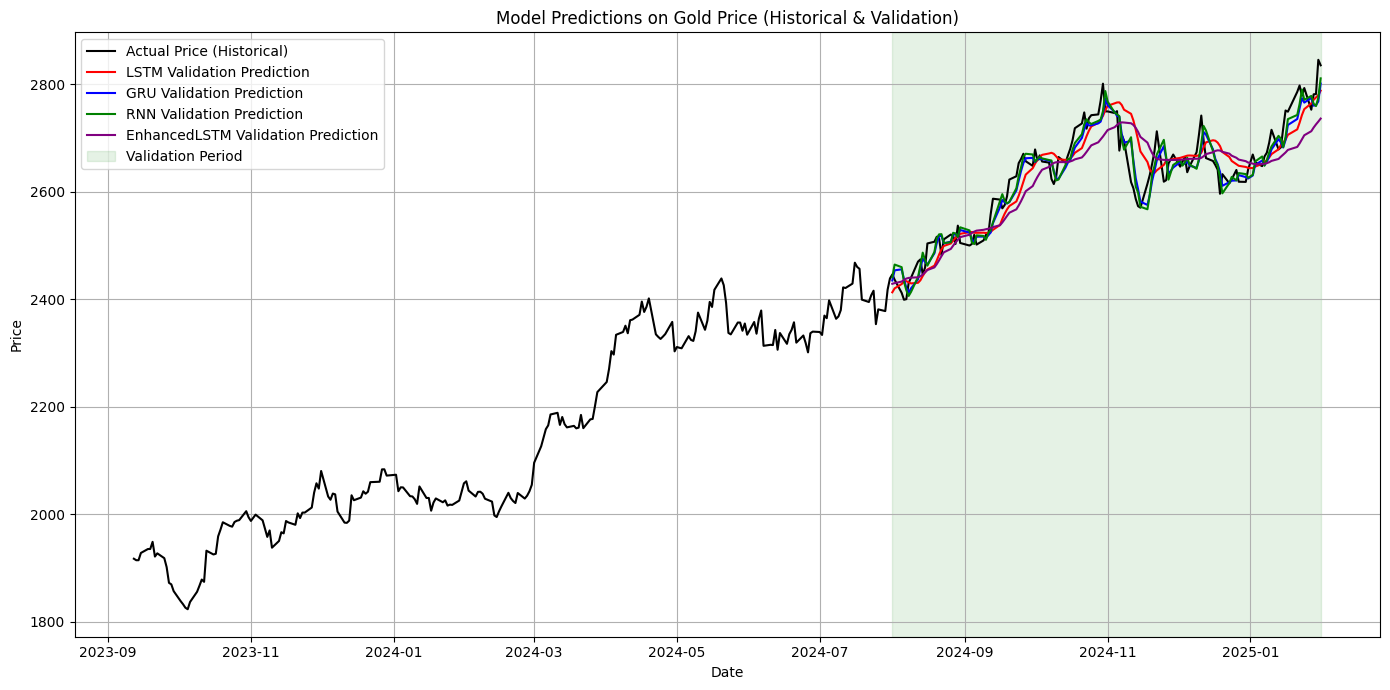

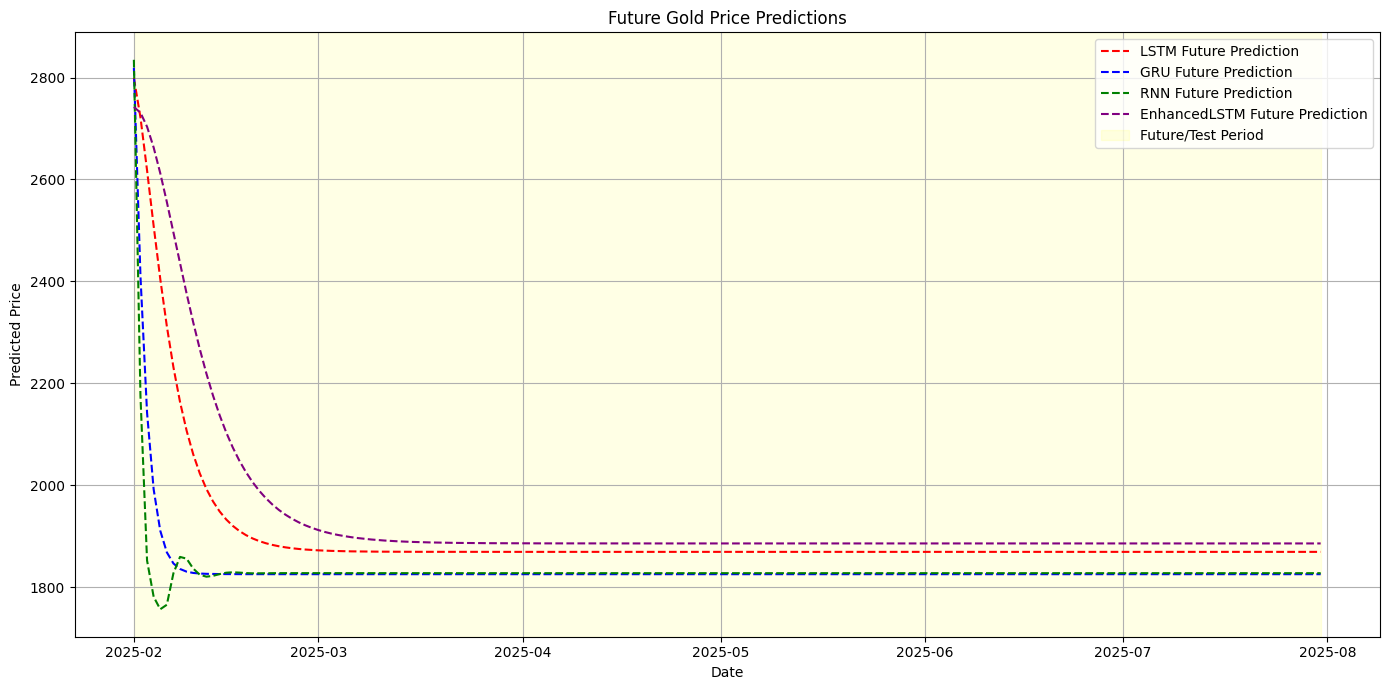

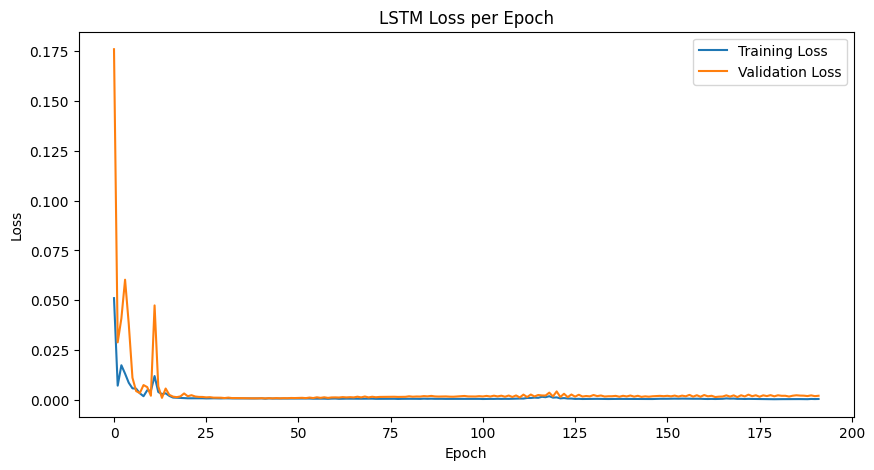

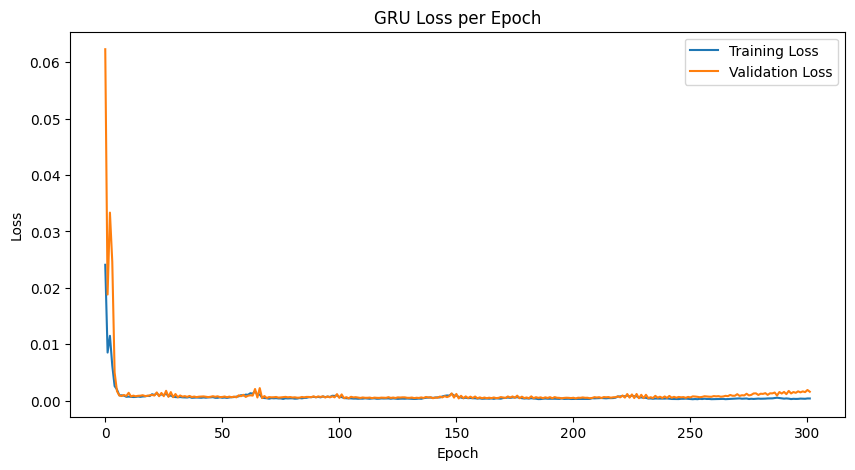

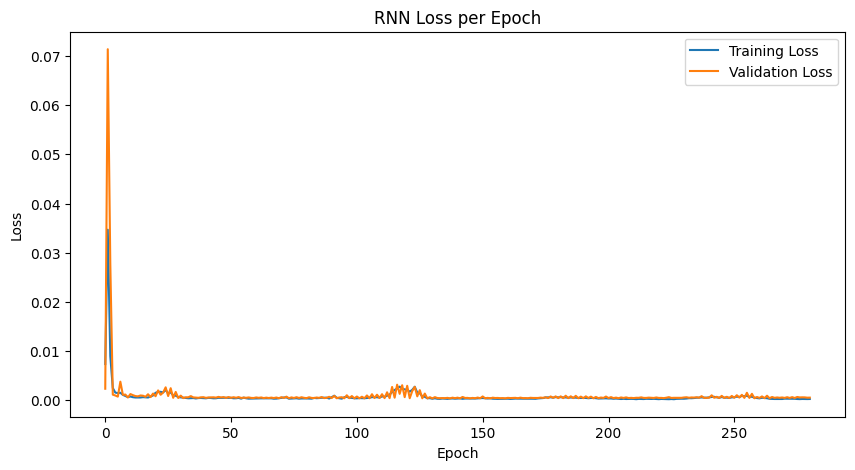

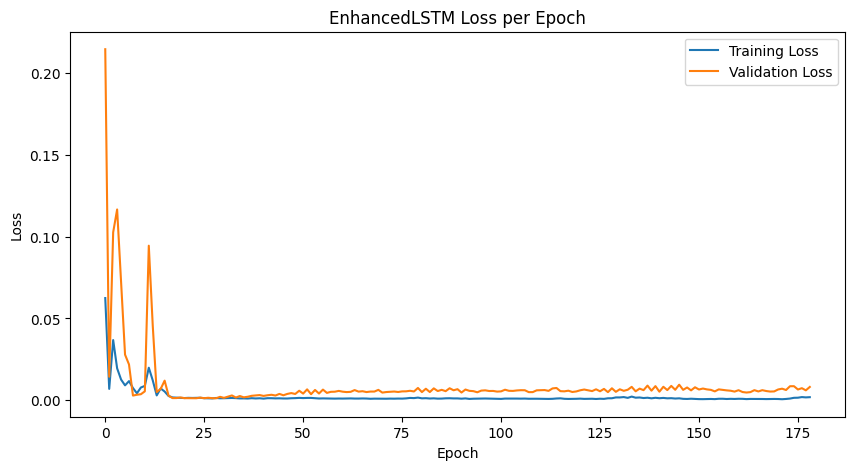

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# -----------------------
# Data Loading & Preparation
# -----------------------

df = pd.read_csv('Gold Futures Historical Data_1Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert numeric columns (remove commas if any)
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and missing values
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Define the features to use (target is 'Price')
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale each feature individually
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# -----------------------
# Create Sliding Windows for Sequence-to-One Prediction
# -----------------------

window_width = 30  # Adjust window width as needed

X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # target: scaled 'Price'
    dates.append(df['Date'].iloc[i])
    
X = np.array(X)
y = np.array(y)
dates = np.array(dates)

assert len(dates) == len(y), "Mismatch between dates and target length"

# -----------------------
# Split into Training & Validation Sets
#    Training: before 2024-08-01
#    Validation: 2024-08-01 to 2025-01-31
# -----------------------

train_mask = dates < pd.to_datetime('2024-08-01')
val_mask = (dates >= pd.to_datetime('2024-08-01')) & (dates <= pd.to_datetime('2025-01-31'))

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)

# Create TensorDatasets and DataLoaders (no shuffle for time series)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------
# Model Definitions (CNN Removed)
# -----------------------

class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
            
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
            
        elif model_type == 'RNN':
            # Use 'tanh' activation for stability
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='tanh',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
            
        elif model_type == 'EnhancedLSTM':
            # Slightly deeper LSTM with mild dropout
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.1,
            )
            self.dropout = nn.Dropout(0.1)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', or 'EnhancedLSTM'.")
    
    def forward(self, x):
        if self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# -----------------------
# Early Stopping
# -----------------------

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# -----------------------
# Inverse Transformation for 'Price' Only
# -----------------------

def inverse_transform(y_scaled):
    """
    Given scaled 'Price' predictions, reconstruct original scale.
    Other features are set to zero.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# -----------------------
# Training, Validation, and Future Forecasting
# -----------------------

def train_and_evaluate(model_name):
    # Initialize model
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 1500
    best_val_loss = float('inf')
    
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    best_model_path = f'best_model_{model_name}_1yr_datasets.pt'
    
    # Load existing model if available (optional)
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            # Gradient clipping for RNN models
            if model_name == 'RNN':
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs} -- '
                  f'Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    print(f"[{model_name}] Best Validation Loss: {best_val_loss:.6f}")
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # --- Generate Predictions on the Validation Set ---
    model.eval()
    y_val_pred_list = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred_list.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred_list, axis=0)
    y_val_pred_inv = inverse_transform(y_val_pred)
    
    # --- Iterative Forecasting for Future Predictions (2025-02-01 to 2025-07-31) ---
    future_start_date = pd.to_datetime('2025-02-01')
    future_end_date = pd.to_datetime('2025-07-31')
    num_future_steps = (future_end_date - future_start_date).days + 1
    
    last_window = data_scaled[-window_width:]  # last window of scaled historical data
    current_window = last_window.copy()
    future_predictions_scaled = []
    
    with torch.no_grad():
        for _ in range(num_future_steps):
            input_tensor = torch.from_numpy(current_window[np.newaxis, :]).float().to(device)
            pred = model(input_tensor)
            pred_value = pred.item()
            future_predictions_scaled.append(pred_value)
            new_row = np.zeros((1, len(features)))
            new_row[0, 0] = pred_value
            current_window = np.vstack((current_window[1:], new_row))
    
    y_future_pred_inv = inverse_transform(future_predictions_scaled)
    future_dates = pd.date_range(start=future_start_date, end=future_end_date)
    
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'future_dates': future_dates,
        'y_future_pred_inv': y_future_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    return results

# -----------------------
# Train & Evaluate (CNN Removed)
# -----------------------

model_names = ['LSTM', 'GRU', 'RNN', 'EnhancedLSTM']
all_results = {}

for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# -----------------------
# Plotting: Validation and Future Predictions
# -----------------------

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'EnhancedLSTM': 'purple',
}

# 1) Plot historical actual prices + validation predictions
plt.figure(figsize=(14, 7))
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price (Historical)')

for model_name, results in all_results.items():
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )

plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.title('Model Predictions on Gold Price (Historical & Validation)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Plot future (test) predictions (no actual data)
plt.figure(figsize=(14, 7))
for model_name, results in all_results.items():
    plt.plot(
        results['future_dates'],
        results['y_future_pred_inv'],
        color=model_colors[model_name],
        linestyle='--',
        label=f'{model_name} Future Prediction'
    )

plt.axvspan(pd.to_datetime('2025-02-01'), pd.to_datetime('2025-07-31'),
            color='yellow', alpha=0.1, label='Future/Test Period')
plt.title('Future Gold Price Predictions')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) (Optional) Loss curves per model
for model_name, results in all_results.items():
    plt.figure(figsize=(10, 5))
    plt.plot(results['train_losses_per_epoch'], label='Training Loss')
    plt.plot(results['val_losses_per_epoch'], label='Validation Loss')
    plt.title(f'{model_name} Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Price_Year 2018_Test.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')


# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width
window_width = 30  # Adjusted window width for experimentation

# Prepare sequences and corresponding dates
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# Split the data into training, validation, and test sets based on dates
train_mask = dates < pd.to_datetime('2018-10-24')
val_mask = (dates >= pd.to_datetime('2018-10-24')) & (dates < pd.to_datetime('2018-11-28'))
test_mask = dates >= pd.to_datetime('2018-11-28')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle=False for sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### All the above are the data cleaning and preparation steps ### 


# Define the models
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate the output size after Conv1d layers
            # Each Conv1d layer reduces the sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2 * (3 - 1)  # Two Conv1d layers with kernel_size=3
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, channels, seq_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# Function to train and evaluate a model
def train_and_evaluate(model_name):
    # Initialize the model
    model = BaseModel(model_type=model_name).to(device)
    
    # Define the criterion, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 800
    best_val_loss = float('inf')
    
    # Lists to store loss history
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    # Path to save the best model checkpoint
    best_model_path = f'best_model_{model_name}.pt'
    
    # Check if a saved model exists and load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        # Scheduler step
        scheduler.step(avg_val_loss)
        
        # Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        # Print losses every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    
    # Evaluate on test data
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    # Concatenate test predictions
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    
    # Calculate MAPE and accuracy
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # Collect predictions over validation and test sets
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    y_test_pred = y_test_pred_array
    
    # Inverse scaling
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred)
    
    # Store results
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    
    return results

# List of models to train
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Dictionary to store results
all_results = {}
    
# Train and evaluate each model
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual validation and test target values
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

# Actual Price
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

# Plot predicted data for each model over validation and test datasets only
for model_name, results in all_results.items():
    # Plot validation predictions
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )
    # Plot test predictions
    plt.plot(
        results['test_dates'],
        results['y_test_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Test Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Model Predictions on Gold Price (Validation and Test Periods Only)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in plot for validation and test data with dashed lines for models
plt.figure(figsize=(14, 7))

# Combine validation and test dates and actual prices
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual prices for validation and test periods
plt.plot(
    zoom_dates,
    zoom_actual,
    color='black',
    label='Actual Price'
)

# Plot predicted data for each model during validation and test periods with dashed lines
for model_name, results in all_results.items():
    # Combine validation and test predictions
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((results['val_dates'], results['test_dates']))
    plt.plot(
        model_dates,
        y_pred_combined,
        color=model_colors[model_name],
        linestyle='--',  # Dashed lines
        label=f'{model_name} Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation and Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Training LSTM model...
Loaded existing model for LSTM from best_model_LSTM.pt
[LSTM] Epoch 100/800, Training Loss: 0.000544, Validation Loss: 0.000840
[LSTM] Epoch 200/800, Training Loss: 0.000325, Validation Loss: 0.000998
Early stopping triggered
[LSTM] Early stopping at epoch 218
[LSTM] Test Loss: nan


ValueError: Input contains NaN.